Notebook to generate data file that is a subset of the SGA catalog with rotational velocities measured during Y3
(jura).

In [1]:
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
c = const.c.to('km/s')

q0 = 0.2

# Data

## jura

In [3]:
tjura = Table.read('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/desi_pv_tf_jura_healpix.fits')
tjura

TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64
-430502046,134.00013295228783,5.934552839997555,134.0000012447711,5.934402495943119,0.0,0.0,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S,0.0,0.0
-427872363,61.981718642816155,-22.823913110732356,61.981815755036905,-22.824112647850505,0.01692960597574711,0.01899055577814579,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S,0.0,0.0
-411444222,156.2181500220905,7.1584828480845655,156.21807676457115,7.1586258676041306,0.0,0.0,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S,0.0,0.0
-261707523,51.18809619857989,-15.380001206793725,51.18805131712048,-15.379972719695512,0.18443052470684052,0.270201712846756,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S,0.0,0.0
-260779407,138.32747528464944,17.5639019859795,138.32760054746495,17.56391743552376,0.0,0.0,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S,0.0,0.0
-256075243,267.7127650902238,29.4851124724098,267.7127035487433,29.485378196733514,0.0,0.0,0.024938748634094107,2.4256075629217488e-05,GALAXY,1541.527919426706,2560,SGA,447725,S,0.0,0.0
-255779143,324.7514856412927,-14.285073192391051,324.75157640573354,-14.285173696560276,0.0,0.0,0.06222014597085957,1.2531392899106468e-05,GALAXY,13019.724023681134,2560,SGA,344696,S,0.0,0.0
-255474428,318.1164926597467,-5.284018993812088,318.1164721848627,-5.284046207257645,0.0,0.0,0.048956092264502225,7.806082205296064e-05,GALAXY,65.2918488328578,512,TFT,342501,S,0.0,0.0
-253178294,171.33824183216043,53.64134341804524,171.33828946114534,53.64163818459112,0.0,0.0,0.033601461542572625,3.5901373601923224e-06,GALAXY,2593.072873726487,2560,TFT,32805,N,0.0,0.0


## SGA

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
#SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [5]:
# tjura['SGA_ID'] = tjura['SGA_ID'].astype('int32')
# tjura.write('/global/homes/s/sgmoore1/DESI_SGA/TF/queries/jura_test.fits',overwrite=True)

In [6]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

# Separate the JURA data into center and off-center observations

In [7]:
tjura['SKY_FIBER_DIST'] = 0.
tjura['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tjura['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tjura['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tjura['MEAN_FIBER_RA'][obs_idx], 
                             dec=tjura['MEAN_FIBER_DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tjura['SKY_FIBER_DIST'][obs_idx] = sep2d
    tjura['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|██████████| 146579/146579 [09:10<00:00, 266.20it/s]


In [8]:
centers_boolean = tjura['SKY_FIBER_DIST_R26'] < 0.1
jura_centers = tjura[centers_boolean]
jura_axis = tjura[~centers_boolean]

## Clean the jura center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0
* passed VI

In [9]:
good_centers = jura_centers[(jura_centers['DELTACHI2'] > 25) & (jura_centers['ZWARN'] == 0)]
print(len(np.unique(good_centers['SGA_ID'])), len(good_centers))

138013 152733


In [10]:
#Come back and redo this one after the VI step

# jura_VI = Table.read('jura_VI.txt', format='ascii.commented_header')

# centers_VI = np.ones(len(good_centers), dtype=bool)

# for targetid in jura_VI['TARGETID']:
    
#     if targetid in good_centers['TARGETID']:
#         centers_VI = centers_VI & (good_centers['TARGETID'] != targetid)
        
# good_centers_VI = good_centers[centers_VI]
# print(len(np.unique(good_centers_VI['SGA_ID'])), len(good_centers_VI))

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

100%|██████████| 138013/138013 [00:47<00:00, 2936.09it/s]


# Calculate the rotational velocities

In [12]:
jura_axis['SKY_FIBER_DIST'] = 0.
jura_axis['SKY_FIBER_DIST_R26'] = 0.
jura_axis['V_ROT'] = np.nan
jura_axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = jura_axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=jura_axis['MEAN_FIBER_RA'][obs_idx], 
                             dec=jura_axis['MEAN_FIBER_DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    jura_axis['SKY_FIBER_DIST'][obs_idx] = sep2d
    jura_axis['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    jura_axis['V_ROT'][obs_idx] = c*(jura_axis['Z'][obs_idx] - z_center)
    jura_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(jura_axis['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    jura_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

 97%|█████████▋| 133935/138013 [08:05<00:14, 277.41it/s]/tmp/ipykernel_903892/1085777904.py:56: RuntimeWarning: divide by zero encountered in true_divide
  jura_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
100%|██████████| 138013/138013 [08:20<00:00, 275.96it/s]


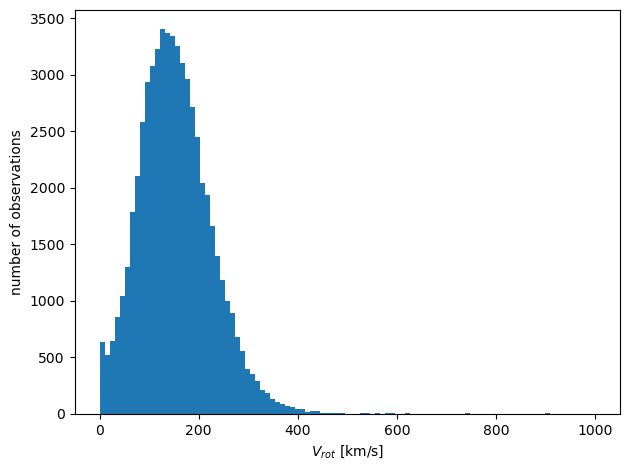

In [13]:
plt.figure(tight_layout=True)

plt.hist(np.abs(jura_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Quality criteria for velocities

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.4R_{26}$
* $\Delta V / V_{min} \leq 5$
* passes VI

## Velocity cut

In [14]:
r0p4 = (jura_axis['SKY_FIBER_DIST_R26'] > 0.38) & (jura_axis['SKY_FIBER_DIST_R26'] < 0.42)

Vgood = (np.abs(jura_axis['V_ROT']) < 1000) & (np.abs(jura_axis['V_ROT']) > 10)

good_axis = jura_axis[r0p4 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

57801 36513


## Visual inspection

Cutouts for this were generated with the `TF_Y1_VI.ipynb` notebook.

In [15]:
#Come back and run this cell after the VI.

# axis_VI = np.ones(len(good_axis), dtype=bool)

# for targetid in jura_VI['TARGETID']:
    
#     if targetid in good_axis['TARGETID']:
#         axis_VI = axis_VI & (good_axis['TARGETID'] != targetid)
        
# good_axis_VI = good_axis[axis_VI]
# print(len(good_axis_VI), len(np.unique(good_axis_VI['SGA_ID'])))

## Relative velocity cut

In [16]:
#Will need to redo this with good_axis_VI after the visual inspection

good_deltaV = np.ones(len(good_axis), dtype=bool)

for sga_id in tqdm(np.unique(good_axis['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

100%|██████████| 36513/36513 [00:08<00:00, 4326.95it/s]


In [17]:
#Will need to redo post-VI

good_deltaV_axis = good_axis[good_deltaV]

print(len(good_deltaV_axis), len(np.unique(good_deltaV_axis['SGA_ID'])))

57634 36471


# Compute the weighted average velocity for those galaxies with more than one observation at $0.4R_{26}$

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$

In [18]:
SGA['V_0p4R26'] = np.nan
SGA['V_0p4R26_err'] = np.nan

weights = 1./(good_deltaV_axis['V_ROT_ERR']**2)

for sga_id in tqdm(np.unique(good_deltaV_axis['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_deltaV_axis['SGA_ID'] == sga_id
    
    SGA['V_0p4R26'][SGA_dict[sga_id]] = np.average(np.abs(good_deltaV_axis['V_ROT'][obs_idx]), 
                                                   weights=weights[obs_idx])

    SGA['V_0p4R26_err'][SGA_dict[sga_id]] = np.sqrt(1./np.sum(weights[obs_idx]))

100%|██████████| 36471/36471 [00:08<00:00, 4384.38it/s]


In [19]:
# Make a catalog of just those galaxies with velocities
SGA_TF_jura = SGA[np.isfinite(SGA['V_0p4R26']) & (SGA['R_MAG_SB26'] > 0)]

In [20]:
#When it is confirmed that this is a good file to go with, write to here

# SGA_TF_jura.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/SGA-2020_jura_Vrot.fits')
# SGA_TF_jura.write('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/SGA-2020_jura_Vrot_VI.fits', 
                  # overwrite=True)

In [21]:
SGA_TF_jura.write('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/SGA-2020_jura_Vrot.fits', overwrite=True)

In [22]:
SGA_TF_jura

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64
20,SGA-2020 20,SDSSJ173412.71+572041.6,3331584,263.5529355,57.34490699999999,S?,152.58,0.4487454,0.5333349,0.08364453,24.92448,18.036,False,LEDA-20181114,5,SDSSJ173412.71+572041.6,1,True,263.5529355,57.34490699999999,0.4487454,2635p572,263.55294849855886,57.344862145664294,0.4460123,SB26,152.3756,0.5778338,263.5528114673963,57.34481025685253,10.459747,5.9780583,5.751067,4.821581,1.4858595,3.4448266,5.1149526,6.748707,8.426254,9.720271,11.022999,12.0887985,13.380368,20.656942,20.044735,19.40886,19.194794,18.66572,18.231262,18.599888,18.123905,17.745926,18.256256,17.807074,17.476473,18.040592,17.60353,17.319197,17.926336,17.500519,17.228865,17.85259,17.42695,17.180876,17.811844,17.39206,17.151228,17.783718,17.36542,17.143204,0.02069058,0.026094317,0.03480586,0.05076174,0.08751116,0.10309491,0.08337893,0.10982923,0.13734566,0.031223593,0.046367057,0.0777883,0.015935475,0.020728666,0.032657374,0.012760426,0.014699919,0.022893604,0.010505663,0.011998588,0.018923525,0.010358521,0.011374098,0.017719442,0.010557283,0.0112259,0.017149422,0.010553381,0.011049819,0.017135512,0.010413324,0.010993488,0.01699026,0.010291049,0.010862263,0.017057167,17.6411,0.6362121,0.53480667,2.8045392,1.7123051,17.22401,0.6144014,0.53440714,2.7180903,2.1161501,17.062769,0.44818503,0.43006793,3.1755726,0.97457016,0,0.08361389105924856,5.969831206665643e-06,147.82237894320167,4.528884919879512
32,SGA-2020 32,PGC2644444,2644444,212

In [23]:
SGA_TF_jura.write('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/Y3/SGA-2020_jura_Vrot.fits', overwrite=True)